In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, BatchNormalization,
    AdditiveAttention, Dense, Flatten, Permute, Reshape, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

features = ['Close', 'Open', 'Range', 'MA20', 'MA50']


def train_lstm_model(
    csv_path,
    sequence_length=100,
    batch_size=25,
    epochs=100,
    validation_split=0.2,
    patience=10,
    cutoff_date='2015-01-01',
):
    """
    Trains an LSTM model with attention mechanism on stock Close price data.

    Returns:
        model, history, close_scaler, input_scaler
    """
    # --- Load and Preprocess Data ---
    #data = pd.read_csv(csv_path).drop(columns=['Date'])
    data = pd.read_csv(csv_path)
    data = data[data['Date'] >= cutoff_date].reset_index(drop=True).drop(columns=['Date'])


    # --- Scale inputs and Close separately ---
    input_scaler = MinMaxScaler()
    input_scaled = input_scaler.fit_transform(data[features])

    close_scaler = MinMaxScaler()
    close_scaled = close_scaler.fit_transform(data[['Close']])

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(input_scaled)):
        X.append(input_scaled[i-sequence_length:i])  # (100, 5)
        y.append(close_scaled[i, 0])  # target is scaled Close

    X = np.array(X)
    y = np.array(y)

    # Train/Test Split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # --- Build Model ---
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    x = LSTM(50, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = LSTM(50, return_sequences=True)(x)

    # Attention mechanism
    permute = Permute((2, 1))(x)
    reshape = Reshape((50, X_train.shape[1]))(permute)
    attention = AdditiveAttention(name='attention_weight')([reshape, reshape])
    attention = Permute((2, 1))(attention)
    attention = Reshape((X_train.shape[1], 50))(attention)

    x = Multiply()([x, attention])
    x = Flatten()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- Callbacks ---
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)
    csv_logger = CSVLogger('training_log.csv')

    # --- Train Model ---
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, csv_logger]
    )

    # --- Evaluate Model ---
    y_pred = model.predict(X_test)
    y_pred_real = close_scaler.inverse_transform(y_pred)
    y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))

    mae_real = mean_absolute_error(y_test_real, y_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

    print(f"Real MAE: ${mae_real:.2f}")
    print(f"Real RMSE: ${rmse_real:.2f}")

    # Save scalers for reuse
    joblib.dump(close_scaler, 'models/close_only_scaler.save')
    joblib.dump(input_scaler, 'models/input_feature_scaler.save')

    return model, history, close_scaler, input_scaler


def plot_training_history(history, save_path=None):
    """
    Plots the training and validation loss from a Keras model history.

    Args:
        history: History object returned by model.fit()
        save_path (str, optional): If provided, saves the plot to this filepath.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot
        print(f"Training history plot saved to {save_path}")

    plt.show()

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0149 - val_loss: 0.2420
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 9.5919e-04 - val_loss: 0.2303
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 6.5208e-04 - val_loss: 0.1998
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 5.9702e-04 - val_loss: 0.1336
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.5743e-04 - val_loss: 0.0860
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.4868e-04 - val_loss: 0.0395
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.6446e-04 - val_loss: 0.0303
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 3.5604e-04 - val_loss: 0.0116
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 2.4575e-04 - val_loss: 0.0108
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 3.2821e-04 - val_loss: 0.0059
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.8530e-04 - val_loss: 0.0118
Epoch 12/100

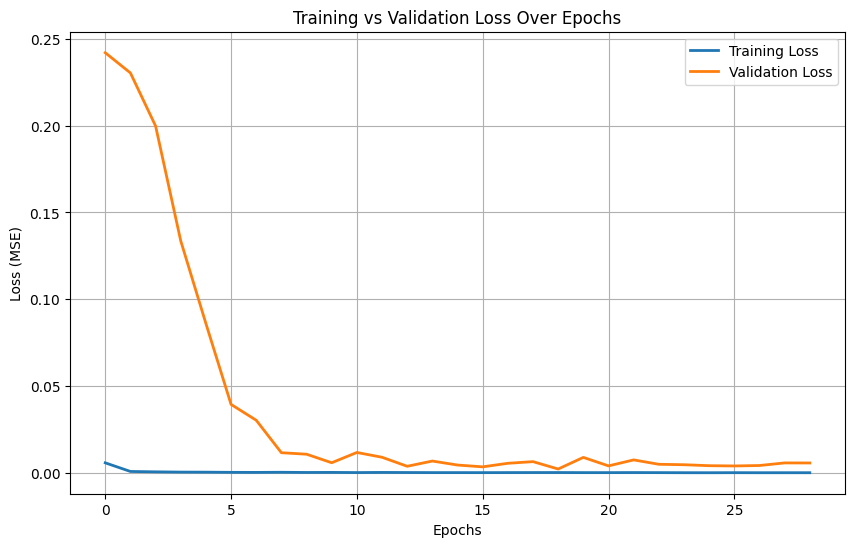

['models/close_only_scaler.save']

In [8]:
import joblib
#print(cleanedStockDataName)
model, history, close_scaler, input_scaler = train_lstm_model(
    'dataset/AAPL_CleanedStockData.csv'
)
plot_training_history(history, save_path='training_history.png')
model.save('models/lstm_attention_model.keras')
# joblib.dump(scaler, 'models/close_scaler.save')
joblib.dump(close_scaler, 'models/close_only_scaler.save')

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


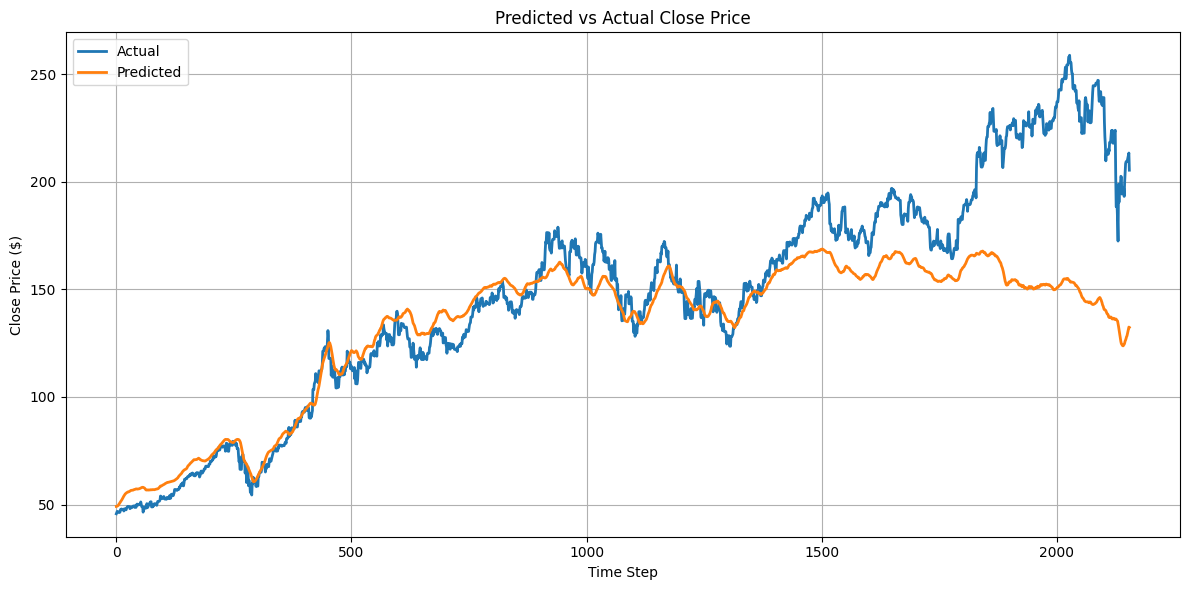

Mean Actual Price: $146.98
MAE: $19.52 (13.28%)
RMSE: $32.10 (21.84%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib

# === SETTINGS ===
csv_path = 'dataset/AAPL_CleanedStockData.csv'
model_path = 'models/lstm_attention_model.keras'
close_scaler_path = 'models/close_only_scaler.save'
input_scaler_path = 'models/input_feature_scaler.save'
features = ['Close', 'Open', 'Range', 'MA20', 'MA50']
sequence_length = 100

# === Load everything ===
data = pd.read_csv(csv_path).drop(columns=['Date'])
close_scaler = joblib.load(close_scaler_path)
input_scaler = joblib.load(input_scaler_path)
model = load_model(model_path)

# === Preprocess ===
input_scaled = input_scaler.transform(data[features])
close_scaled = close_scaler.transform(data[['Close']])

X, y = [], []
for i in range(sequence_length, len(input_scaled)):
    X.append(input_scaled[i-sequence_length:i])
    y.append(close_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Use last 20% for testing
test_size = int(len(X) * 0.2)
X_test = X[-test_size:]
y_test = y[-test_size:]

# === Predict ===
y_pred_scaled = model.predict(X_test)
y_pred_real = close_scaler.inverse_transform(y_pred_scaled)
y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual', linewidth=2)
plt.plot(y_pred_real, label='Predicted', linewidth=2)
plt.title('Predicted vs Actual Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Metrics ===
mean_price = np.mean(y_test_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
percent_mae = (mae / mean_price) * 100
percent_rmse = (rmse / mean_price) * 100

print(f"Mean Actual Price: ${mean_price:.2f}")
print(f"MAE: ${mae:.2f} ({percent_mae:.2f}%)")
print(f"RMSE: ${rmse:.2f} ({percent_rmse:.2f}%)")